In [16]:
import pandas as pd

data_path = "owid-covid-data.csv"
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])
df.head()


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


In [17]:
columns_to_keep = [
    "iso_code","continent","location","date",
    "total_cases","new_cases",
    "total_deaths","new_deaths",
    "total_tests","new_tests",
    "total_vaccinations","new_vaccinations",
    "people_vaccinated","people_fully_vaccinated",
    "population","gdp_per_capita"
]
df = df[columns_to_keep]
df.fillna(0, inplace=True)


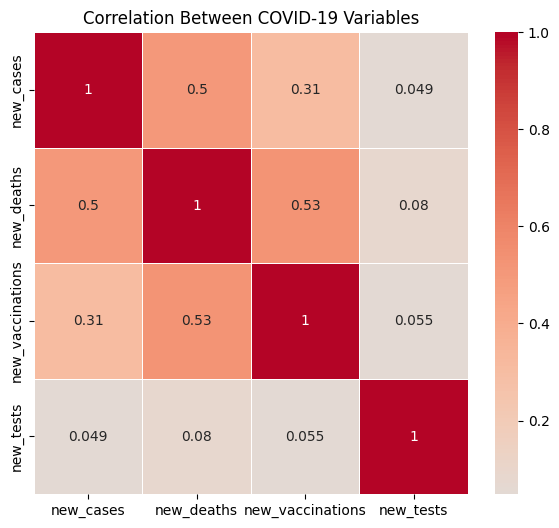

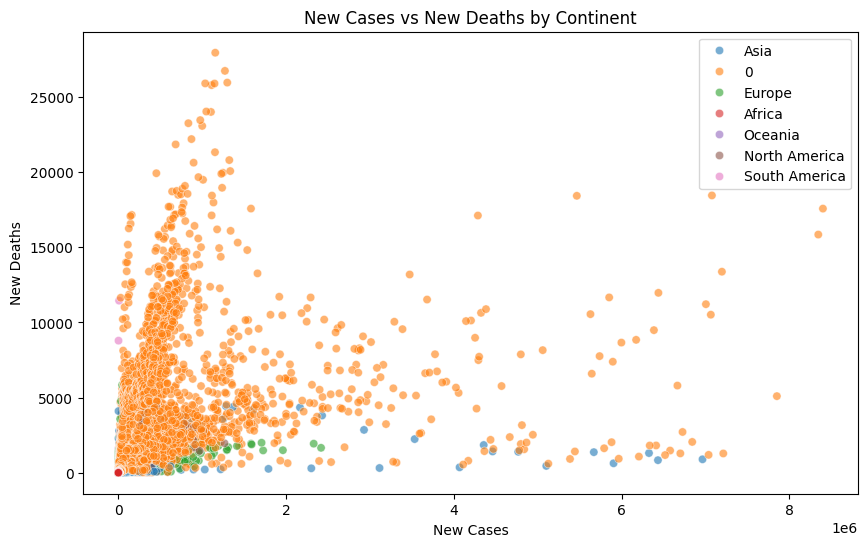

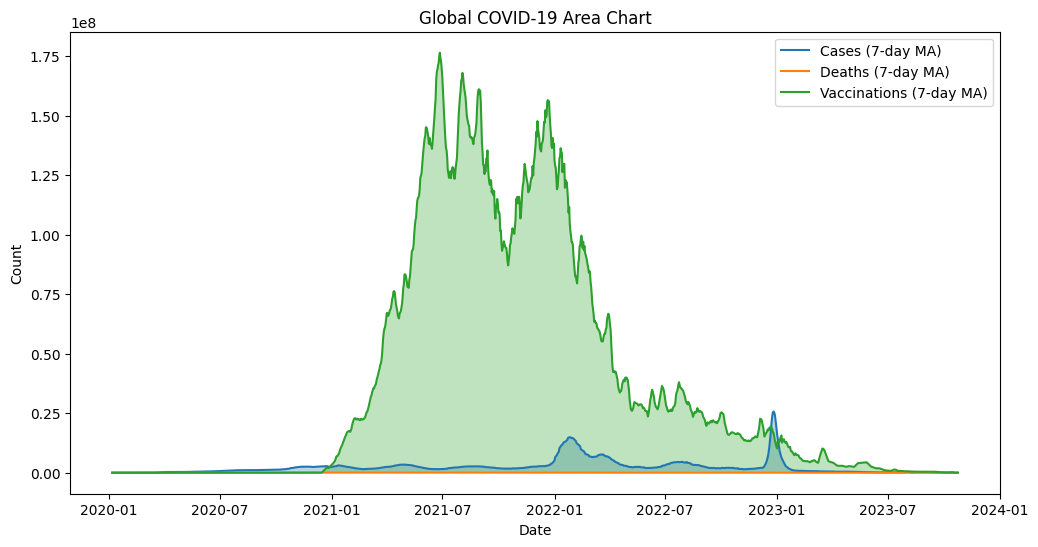

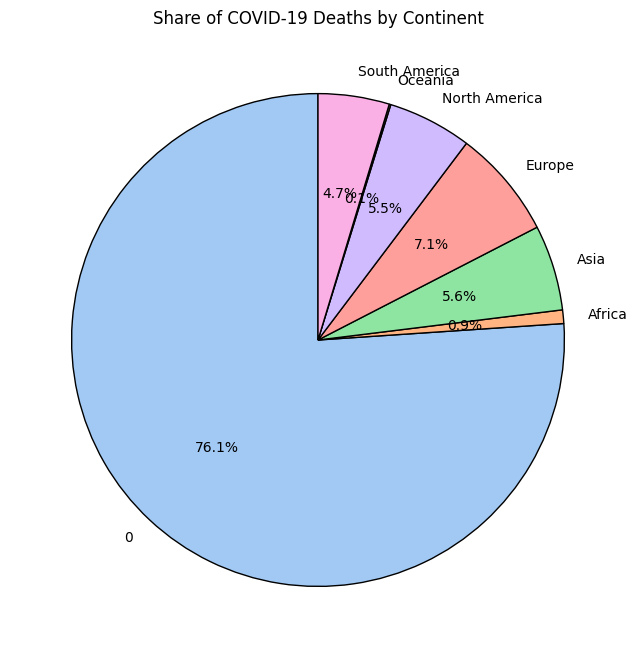

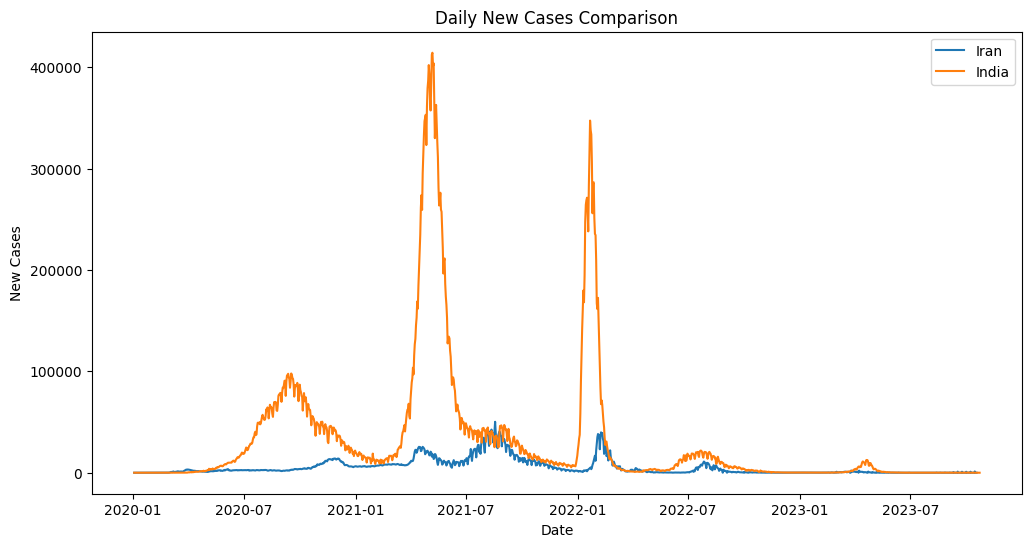

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

df['date'] = pd.to_datetime(df['date'])

world = df.groupby('date')[['new_cases','new_deaths','new_vaccinations']].sum().reset_index()
world['new_cases_ma'] = world['new_cases'].rolling(7).mean()
world['new_deaths_ma'] = world['new_deaths'].rolling(7).mean()
world['new_vaccinations_ma'] = world['new_vaccinations'].rolling(7).mean()

#Heatmap
corr = df[['new_cases','new_deaths','new_vaccinations','new_tests']].corr()
plt.figure(figsize=(7,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5, center=0)
plt.title("Correlation Between COVID-19 Variables")
plt.show()

#Scatter Plot
df_nonzero = df[(df['new_cases'] > 0) & (df['new_deaths'] > 0)]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_nonzero, x='new_cases', y='new_deaths', hue='continent', alpha=0.6)
plt.title("New Cases vs New Deaths by Continent")
plt.xlabel("New Cases")
plt.ylabel("New Deaths")
plt.legend(loc='upper right')
plt.show()

#Line Chart
fig = px.line(
    world,
    x='date',
    y=['new_cases_ma','new_deaths_ma','new_vaccinations_ma'],
    labels={'value':'Count','date':'Date','variable':'Metric'},
    title='Global COVID-19 Trends (7-day MA)'
)
fig.show()

#Area Chart
plt.figure(figsize=(12,6))

plt.fill_between(world['date'], world['new_cases_ma'], alpha=0.3)
plt.plot(world['date'], world['new_cases_ma'], label='Cases (7-day MA)')

plt.fill_between(world['date'], world['new_deaths_ma'], alpha=0.3)
plt.plot(world['date'], world['new_deaths_ma'], label='Deaths (7-day MA)')

plt.fill_between(world['date'], world['new_vaccinations_ma'], alpha=0.3)
plt.plot(world['date'], world['new_vaccinations_ma'], label='Vaccinations (7-day MA)')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Global COVID-19 Area Chart')
plt.legend()
plt.show()

#Bubble Chart
death_map = df.groupby("iso_code").agg({
    "location": "first",
    "continent": "first",
    "total_deaths": "max"
}).reset_index()

death_map = death_map[death_map["continent"].notnull()]
death_map = death_map[death_map["total_deaths"] > 0]

fig = px.scatter_geo(
    death_map,
    locations="iso_code",
    size="total_deaths",
    color="continent",
    hover_name="location",
    hover_data=["total_deaths"],
    projection="natural earth",
    title="Countries with Highest COVID-19 Deaths (Total)"
)
fig.show()

#Pie Chart
continent_sum = df.groupby('continent')['new_deaths'].sum()
colors = sns.color_palette("pastel")[0:len(continent_sum)]

plt.figure(figsize=(8,8))
plt.pie(
    continent_sum,
    labels=continent_sum.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor':'black'},
    colors=colors
)
plt.title("Share of COVID-19 Deaths by Continent")
plt.show()

#Multi-Line Chart
countries = ['Iran','USA','India']
plt.figure(figsize=(12,6))

has_lines = False
for c in countries:
    country_df = df[df['location']==c].groupby('date')['new_cases'].sum()
    if not country_df.empty:
        plt.plot(country_df.index, country_df.values, label=c)
        has_lines = True

if has_lines:
    plt.legend(loc='upper right')

plt.title("Daily New Cases Comparison")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.show()

#Choropleth Map
fig = px.choropleth(
    death_map,
    locations="iso_code",
    color="total_deaths",
    hover_name="location",
    hover_data=["total_deaths"],
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Global Total COVID-19 Deaths (Whole Period)"
)
fig.show()
